In [ ]:
%cd ../tfa

In [2]:
# import dependencies
import tfa as TFA
import utils

02/07/2018 14:09:04 [Epoch 1] (1348ms) Posterior free-energy 1.18710554e+09
02/07/2018 14:09:06 [Epoch 2] (1343ms) Posterior free-energy 1.18682573e+09
02/07/2018 14:09:07 [Epoch 3] (1374ms) Posterior free-energy 1.18661709e+09
02/07/2018 14:09:08 [Epoch 4] (1447ms) Posterior free-energy 1.18645107e+09
02/07/2018 14:09:10 [Epoch 5] (1564ms) Posterior free-energy 1.18632256e+09
02/07/2018 14:09:12 [Epoch 6] (1633ms) Posterior free-energy 1.18622016e+09
02/07/2018 14:09:13 [Epoch 7] (1668ms) Posterior free-energy 1.18614029e+09
02/07/2018 14:09:16 [Epoch 8] (2364ms) Posterior free-energy 1.18609459e+09
02/07/2018 14:09:18 [Epoch 9] (2485ms) Posterior free-energy 1.18603725e+09
02/07/2018 14:09:21 [Epoch 10] (2846ms) Posterior free-energy 1.18599488e+09
02/07/2018 14:09:24 [Epoch 11] (2887ms) Posterior free-energy 1.18601946e+09
02/07/2018 14:09:27 [Epoch 12] (2948ms) Posterior free-energy 1.18595674e+09
02/07/2018 14:09:30 [Epoch 13] (2817ms) Posterior free-energy 1.18600384e+09
02/07/20

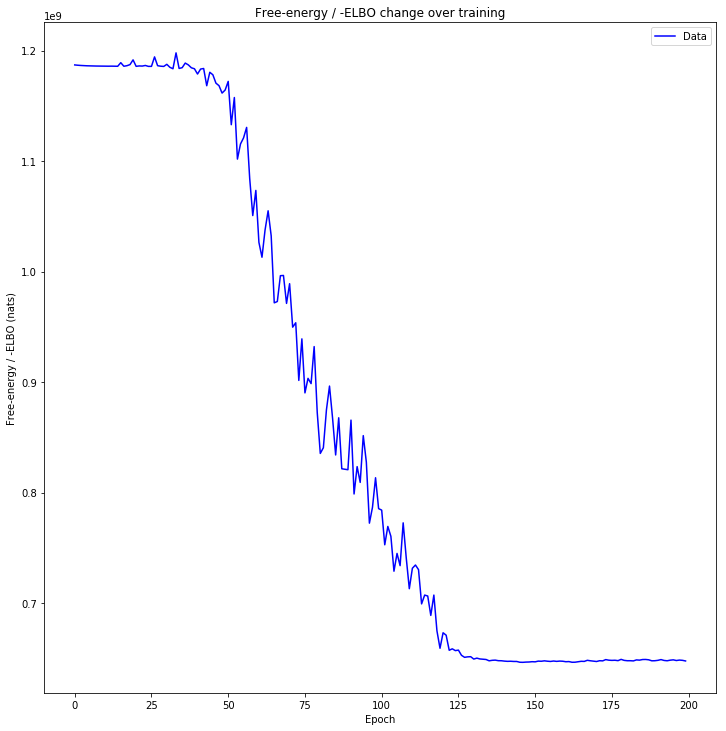

{'weights': array([[[  1.37157321e+00,   1.95021617e+00,   1.54099226e-01, ...,
          -9.77924347e-01,  -6.52265072e-01,   2.59445286e+00],
        [  2.30400264e-01,   5.33236265e+00,   1.90825284e+00, ...,
          -2.45137453e-01,   1.38247752e+00,  -5.65972589e-02],
        [ -2.25631505e-01,  -1.24698710e+00,  -7.53129184e-01, ...,
           2.26182818e-01,   1.65034080e+00,  -8.61883014e-02],
        ..., 
        [  9.98901784e-01,   7.48037815e-01,   8.91240537e-01, ...,
          -1.47561204e+00,   2.86907524e-01,   7.73710430e-01],
        [  3.69155139e-01,  -2.15699863e+00,   3.60637903e-04, ...,
          -1.97049367e+00,  -9.97232318e-01,   5.19209921e-01],
        [  5.59174530e-02,  -1.12599766e+00,   2.59769607e+00, ...,
           4.18765962e-01,   9.83364284e-01,   1.35658637e-01]],

       [[ -5.28740704e-01,   1.16000342e+00,  -3.28535020e-01, ...,
          -1.67996764e-01,   1.56979525e+00,  -4.96499360e-01],
        [ -5.41819394e-01,   8.71204972e-01,  -2

In [4]:
tfa = TFA.TopographicalFactorAnalysis('../notebooks/s0.mat')
losses = tfa.train(num_steps=200, log_optimization=True)

utils.plot_losses(losses)

results = tfa.results()
print(tfa.results())

In [5]:
import hypertools as hyp
import numpy as np
import seaborn as sns

import nilearn.plotting as niplot

from nilearn.input_data import NiftiMasker
import nibabel as nib
import scipy.spatial.distance as sd

from IPython.display import YouTubeVideo, HTML

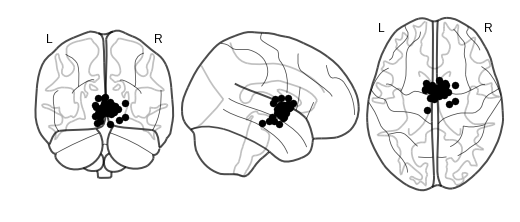

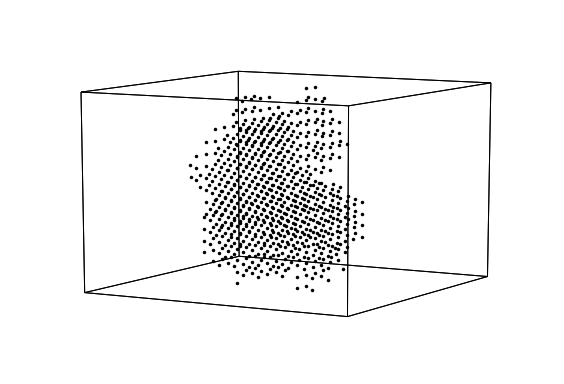

In [10]:
niplot.plot_connectome(np.eye(TFA.NUM_FACTORS), results['factor_centers'][0], node_color='k')
hyp.plot(tfa.voxel_locations.numpy(), 'k.')